In [ ]:
import sys
sys.path.append('~/VEBTF')
sys.path.append('~/VEBTF/src')
from matplotlib import pyplot as plt
from src.vebtf import VEBTF

import numpy as np
from skimage.restoration import denoise_wavelet, estimate_sigma
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
class wavelet_denoise:
    def __init__(self, wavelet='haar', mode='soft', wavelet_levels=None, method='VisuShrink',num_shifts=1,sigma=None):
        self.wavelet = wavelet
        self.mode = mode
        self.wavelet_levels = wavelet_levels
        self.method = method
        self.num_shifts = num_shifts
        self.sigma = sigma

    def fit(self, y):
        """
        Apply translation-invariant wavelet denoising to an y.
        
        Parameters:
        - y: The input y to be denoised.
        - sigma, wavelet, mode, wavelet_levels, convert2ycbcr, method: Parameters for the denoise_wavelet function.
        - num_shifts: Number of shifts for cycle spinning.
        
        Returns:
        - Denoised y with translation-invariant wavelet denoising.
        """
        # mirror the y
        n = len(y)
        y = np.concatenate([y, y[::-1]])
        denoised_y = np.zeros_like(y)
        self.num_shifts = min(self.num_shifts, y.shape[0] - 1)
        shifts = np.linspace(0, y.shape[0] - 1, num=self.num_shifts, dtype=int)
        if self.sigma is None:
            self.sigma = estimate_sigma(y)
        for shift in shifts:
            # Shift the y
            shifted_y = np.roll(y, shift, axis=0)

            # Denoise the shifted y
            denoised_shifted_y = denoise_wavelet(shifted_y, sigma=self.sigma, wavelet=self.wavelet,
                                                    mode=self.mode, wavelet_levels=self.wavelet_levels,method=self.method)

            # Shift back and accumulate the result
            denoised_y += np.roll(denoised_shifted_y, -shift, axis=0)

        # Average the accumulated denoised ys
        denoised_y /= self.num_shifts
        self.mu = denoised_y[0:n]
        #return denoised_y[0:n]


class genlasso_tf:
    def __init__(self,ord=0,k=5):
        self.ord = ord
        self.k = k

    def fit(self, y):
        """
        Apply trend filtering to a given array y with specified order ord.

        Parameters:
        - y: NumPy array containing the input data.
        - ord: Order of the trend filter (0 for piecewise constant, 1 for piecewise linear, etc.).

        Returns:
        - fit_tf: NumPy array containing the trend-filtered output.
        """
        numpy2ri.activate()
        genlasso = importr('genlasso')
        y_r = ro.FloatVector(y)
        fit_tf_r = genlasso.trendfilter(y_r, ord=self.ord)
        fit_tf_cv_r = genlasso.cv_trendfilter(fit_tf_r, k=self.k, verbose=False)
        fit_tf_coef_r = genlasso.coef_genlasso(fit_tf_r, fit_tf_cv_r.rx2('lambda.1se')) 
        fit_tf = np.array(fit_tf_coef_r.rx2('beta'))
        self.mu=fit_tf.squeeze()
        #return fit_tf.squeeze()


class susie_tf:
    def __init__(self,L=20):
        self.L = L

    def fit(self, y):
        """
        Apply trend filtering to a given array y with specified order ord.

        Parameters:
        - y: NumPy array containing the input data.
        - ord: Order of the trend filter (0 for piecewise constant, 1 for piecewise linear, etc.).

        Returns:
        - fit_tf: NumPy array containing the trend-filtered output.
        """
        numpy2ri.activate()
        susieR = importr('susieR')
        y_r = ro.FloatVector(y)
        fit_tf_r = susieR.susie_trendfilter(y_r,L=self.L)
        fit_tf = np.array(susieR.predict_susie(fit_tf_r))
        self.mu = fit_tf.squeeze()
        #return fit_tf.squeeze()
class btf:
    def __init__(self,ord=0,prior='DHS',verbose=False):
        self.ord = ord
        self.prior = prior
        self.verbose = verbose
        self.model_name = f"btf{ord}"

    def fit(self, y):
        """
        Apply Bayesian trend filtering to a given array y with specified order ord.

        Parameters:
        - y: NumPy array containing the input data.
        - ord: Order of the trend filter (0 for piecewise constant, 1 for piecewise linear, etc.).

        Returns:
        - fit_tf: NumPy array containing the trend-filtered output.
        """
        start_time = timeit.default_timer()
        numpy2ri.activate()
        dsp = importr('dsp')
        y_r = ro.FloatVector(y)
        fit_tf = dsp.btf(y_r, D=self.ord, evol_error=self.prior, verbose=self.verbose)
        mu_r = fit_tf.rx2('mu')
        mu_np = np.array(mu_r)
        self.mu=mu_np.mean(axis=0)
        self.run_time = timeit.default_timer() - start_time
class GP_sklearn:
    def __init__(self, kernel='RBF'):
        self.kernel = kernel
        self.model_name = f"GP_{kernel}"

    def fit(self, y):
        """
        Apply Gaussian Process regression to a given array y with specified kernel.

        Parameters:
        - y: NumPy array containing the input data.
        - kernel: Kernel type for the Gaussian Process (default is 'RBF').

        Returns:
        - fit_gp: NumPy array containing the Gaussian Process regression output.
        """
        start_time = timeit.default_timer()
        n = len(y)
        X = np.arange(n).reshape(-1, 1)
        if self.kernel == 'RBF':
            kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1)
        else:
            raise ValueError("Unsupported kernel type.")
        
        gp = GaussianProcessRegressor(kernel=kernel)
        gp.fit(X, y)
        fit_gp = gp.predict(X)
        self.mu=fit_gp.squeeze()
        self.fitted_model = gp
        self.run_time = timeit.default_timer() - start_time

        
import matplotlib.pyplot as plt
import yfinance as yf
import timeit

In [ ]:
import pandas as pd
df = pd.read_csv("~/VEBTF/VEBTF-paper/realdata/dataset/all_six_datasets/ETT-small/ETTh1.csv")
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [144]:
df.shape

(17420, 8)

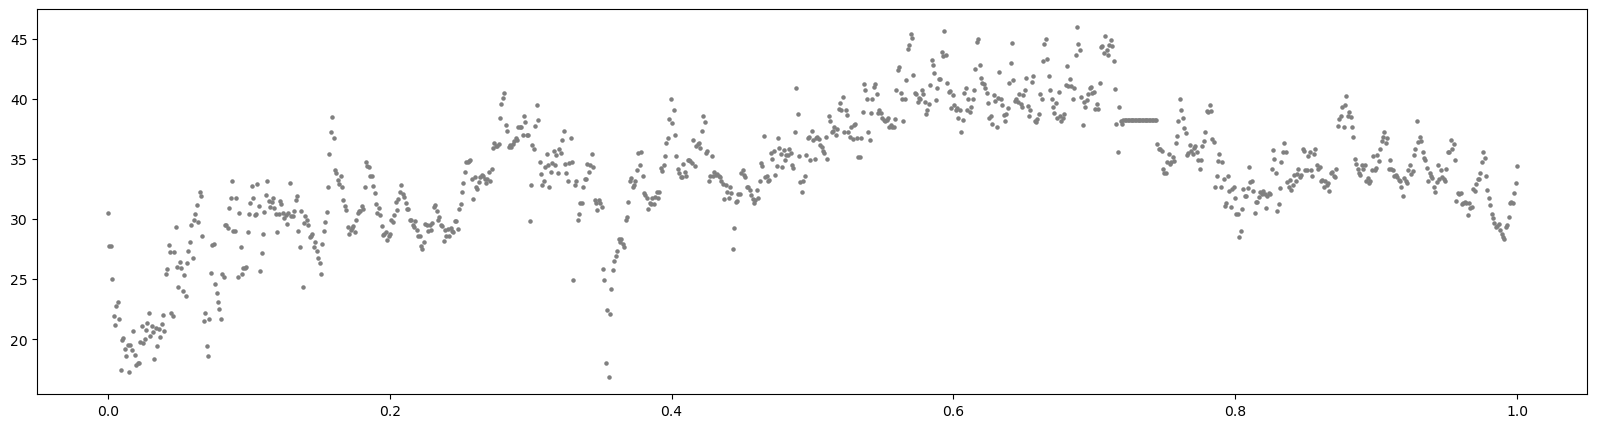

In [145]:
y = df['OT'].values
y = y.squeeze()
n = len(y)
plt.figure(figsize=(20, 5))
plt.scatter(np.linspace(0,1,1000),y[0:1000],color='grey',s=5)
plt.show()

In [193]:
susie20 = susie_tf(L=20)
susie20.fit(y)

R[write to console]: HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.

R[write to console]: HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



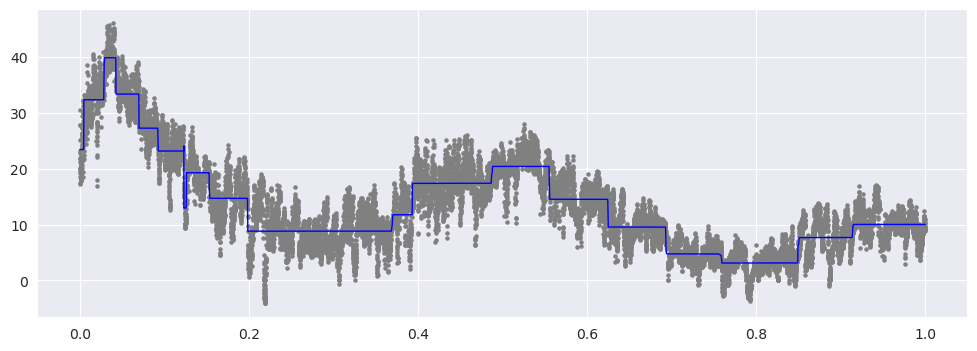

In [196]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
#plt.plot(np.linspace(0,1,len(y)),model.mu, color='black')
plt.plot(np.linspace(0,1,len(y)),susie20.mu, color='blue',linewidth = 1)
#plt.plot(np.linspace(0,1,len(y)),wave.mu, color='red')
plt.show()

In [195]:
susie100 = susie_tf(L=500)
susie100.fit(y)

R[write to console]: HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.

R[write to console]: HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



In [223]:
# save susie100 as pickle
import pickle
with open('results/susie500_etth1.pkl', 'wb') as f:
    pickle.dump(susie100, f)

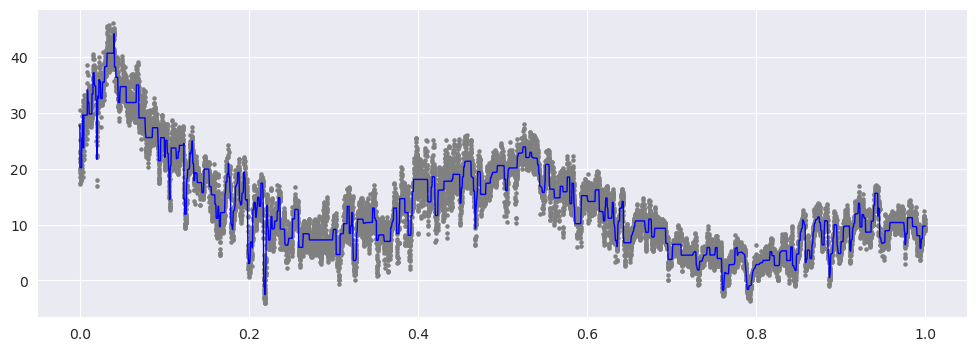

In [198]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
#plt.plot(np.linspace(0,1,len(y)),model.mu, color='black')
plt.plot(np.linspace(0,1,len(y)),susie100.mu, color='blue',linewidth = 1)
#plt.plot(np.linspace(0,1,len(y)),wave.mu, color='red')
plt.show()

In [147]:
n = len(y)
genlasso = genlasso_tf(ord=0,k=5)
genlasso.fit(y)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


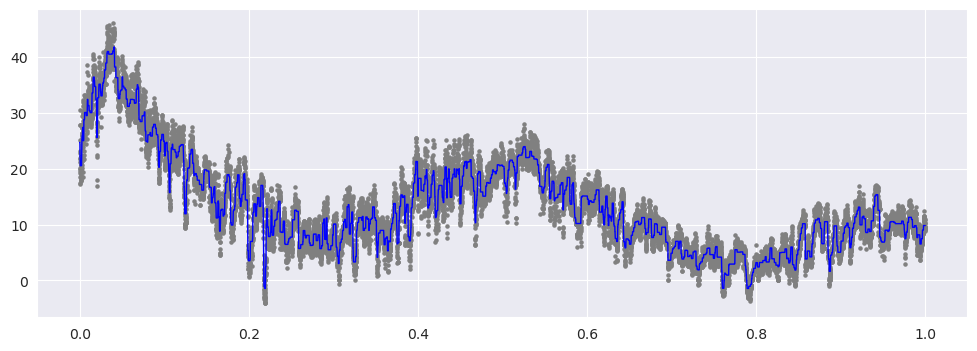

In [157]:
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
#plt.plot(np.linspace(0,1,len(y)),model.mu, color='black')
plt.plot(np.linspace(0,1,len(y)),genlasso.mu, color='blue',linewidth = 1)
#plt.plot(np.linspace(0,1,len(y)),wave.mu, color='red')
plt.show()

In [172]:
model = VEBTF(sigma2=1,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/2,maxiter=1000)
model.fit(y,mu_init = wave.mu)  

Iteration 0: ELBO = -66624.8982354228


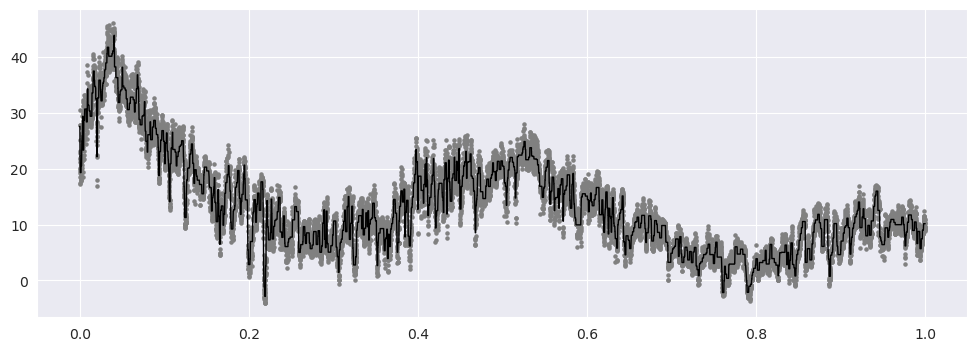

In [156]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),model.mu, color='black',linewidth=1)
# plt.plot(np.linspace(0,1,len(y)),genlasso.mu, color='blue')
#plt.plot(np.linspace(0,1,len(y)),wave.mu, color='red')
plt.show()

In [158]:
wave = wavelet_denoise(wavelet='haar', num_shifts=n)
wave.fit(y)

In [162]:
gp = GP_sklearn(kernel='RBF')
gp.fit(y)

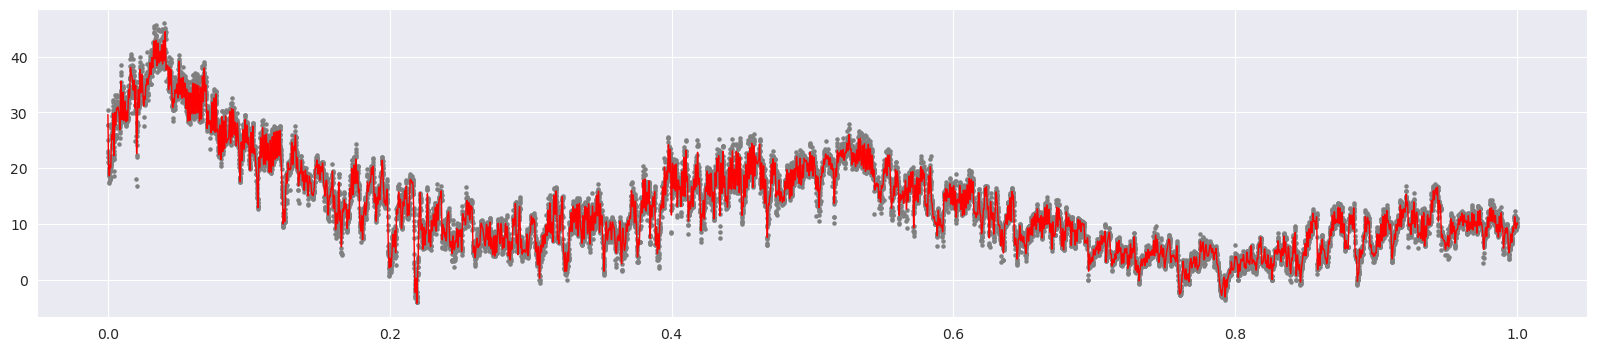

In [165]:
plt.figure(figsize=(20, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
# plt.plot(np.linspace(0,1,len(y)),model.mu, color='black')
# plt.plot(np.linspace(0,1,len(y)),genlasso.mu, color='blue')
plt.plot(np.linspace(0,1,len(y)),gp.mu, color='red',linewidth=1)
plt.show()

In [ ]:
df = df.rename(columns={'OT': 'target'})
df.to_csv("~/VEBTF/VEBTF-paper/realdata/dataset/benchmark/ETTh1.csv", index=False)

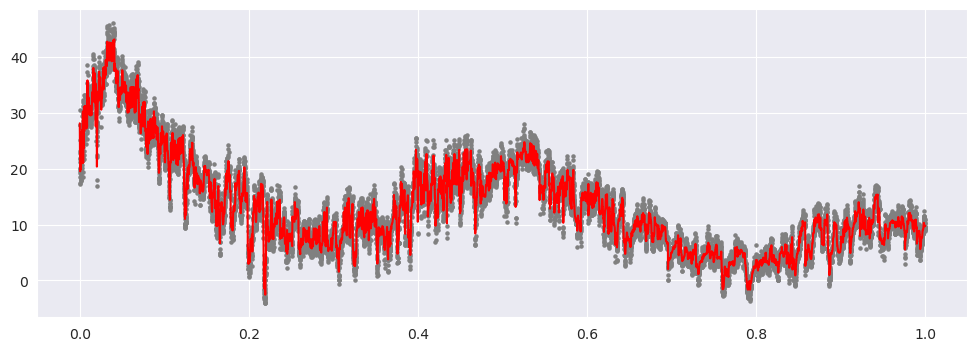

In [160]:
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
# plt.plot(np.linspace(0,1,len(y)),model.mu, color='black')
# plt.plot(np.linspace(0,1,len(y)),genlasso.mu, color='blue')
plt.plot(np.linspace(0,1,len(y)),wave.mu, color='red')
plt.show()

In [167]:
# save gp to a pickle file
import pickle
with open('results/gp_rbf_etth1.pkl', 'wb') as f:
    pickle.dump(gp, f)

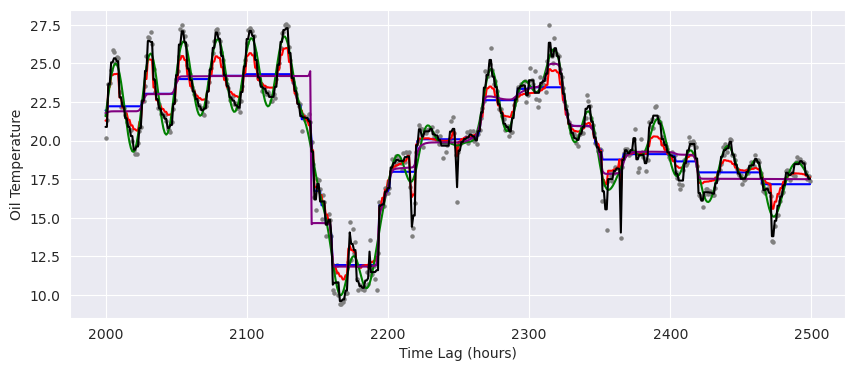

In [218]:
plt.figure(figsize=(10, 4))
x = df['date']
idx = np.arange(2000,2500)
plot_n = len(idx)
plt.scatter(idx,y[idx],color='grey',s=5)
plt.plot(idx,genlasso.mu[idx], color='blue')
plt.plot(idx,wave.mu[idx], color='red')
plt.plot(idx,gp.mu[idx], color='green')
plt.plot(idx,susie100.mu[idx], color='purple')
plt.plot(idx,model.mu[idx], color='black')
plt.legend(['data', 'GenLasso', 'Wavelet', 'GP', 'susie_tf','EBTF'],bbox_to_anchor=(1.04, 1), loc="upper left").remove()
plt.xlabel("Time Lag (hours)")
plt.ylabel("Oil Temperature")
plt.savefig('results/etth1_first.pdf', bbox_inches='tight')
plt.show()

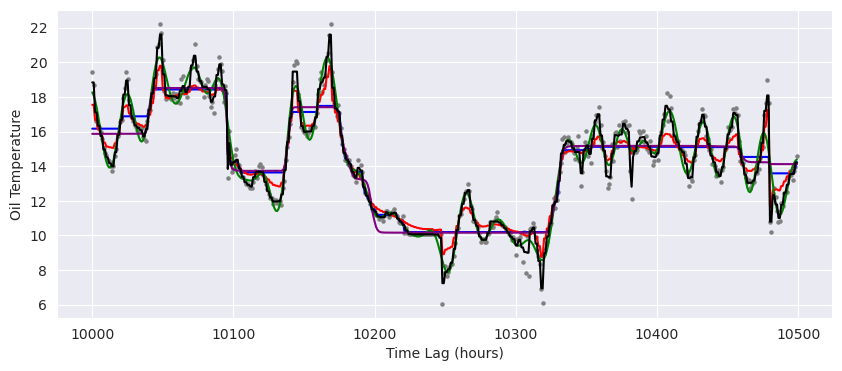

In [219]:
plt.figure(figsize=(10, 4))
x = df['date']
idx = np.arange(10000,10500)
plot_n = len(idx)
plt.scatter(idx,y[idx],color='grey',s=5)
plt.plot(idx,genlasso.mu[idx], color='blue')
plt.plot(idx,wave.mu[idx], color='red')
plt.plot(idx,gp.mu[idx], color='green')
plt.plot(idx,susie100.mu[idx], color='purple')
plt.plot(idx,model.mu[idx], color='black')
plt.legend(['data', 'GenLasso', 'Wavelet', 'GP', 'susie_tf','EBTF'],loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=6).remove()
plt.xlabel("Time Lag (hours)")
plt.ylabel("Oil Temperature")
plt.savefig('results/etth1_second.pdf', bbox_inches='tight')
plt.show()

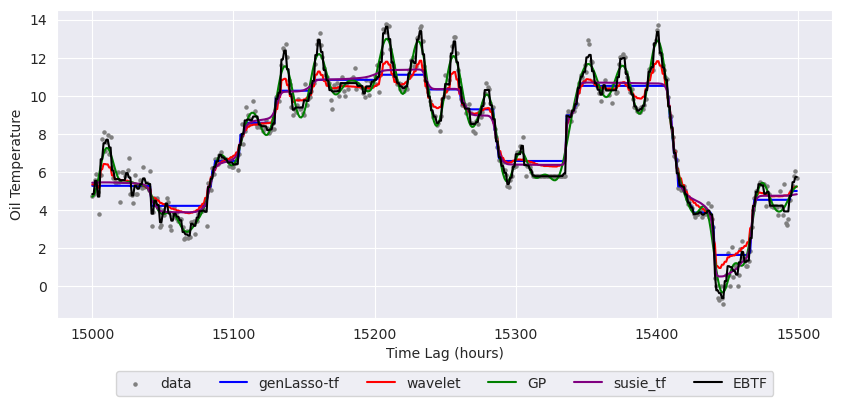

In [221]:
plt.figure(figsize=(10, 4))
x = df['date']
idx = np.arange(15000,15500)
plot_n = len(idx)
plt.scatter(idx,y[idx],color='grey',s=5)
plt.plot(idx,genlasso.mu[idx], color='blue')
plt.plot(idx,wave.mu[idx], color='red')
plt.plot(idx,gp.mu[idx], color='green')
plt.plot(idx,susie100.mu[idx], color='purple')
plt.plot(idx,model.mu[idx], color='black')
plt.legend(['data', 'genLasso-tf', 'wavelet', 'GP', 'susie_tf','EBTF'],loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=6)
plt.xlabel("Time Lag (hours)")
plt.ylabel("Oil Temperature")
plt.savefig('results/etth1_third.pdf', bbox_inches='tight')
plt.show()

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Iteration 0: ELBO = -3106.8252680542096


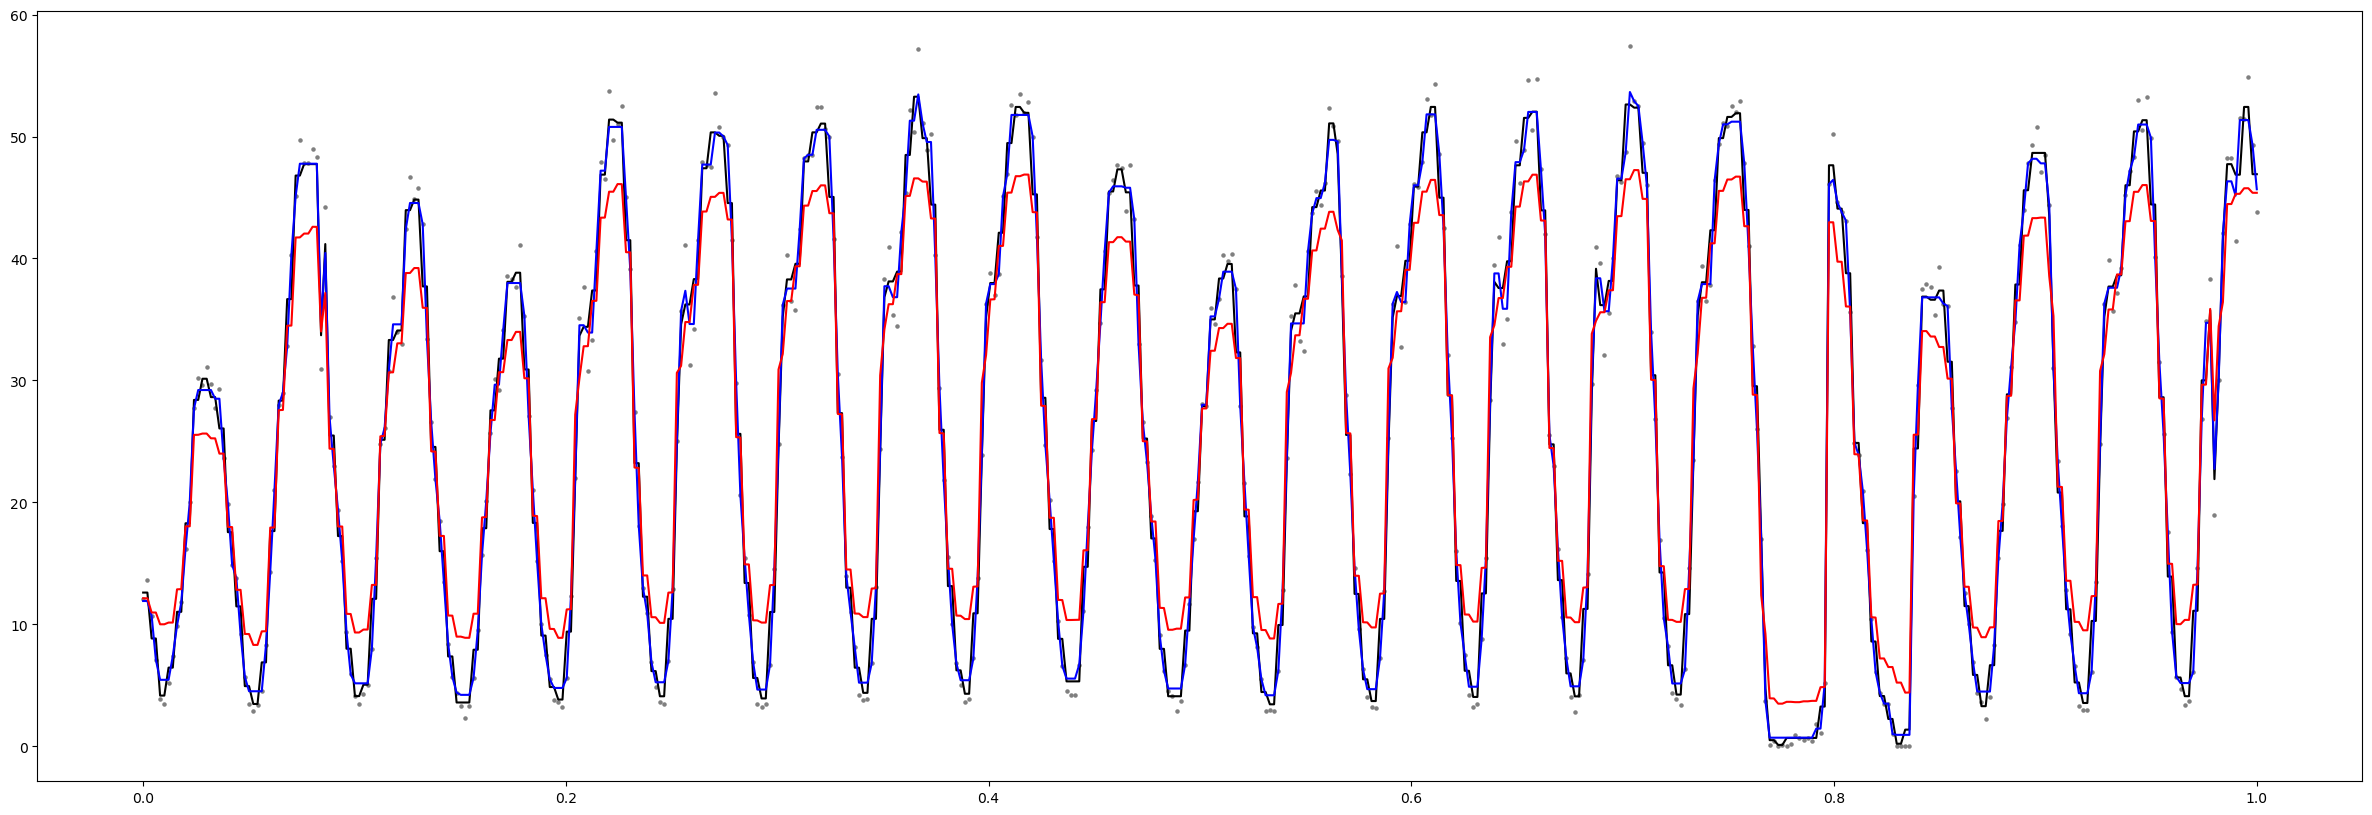

In [140]:
y = y[0:500]
n = len(y)
y = np.array(y,dtype=float)*1000
genlasso = genlasso_tf(ord=0,k=5)
genlasso.fit(y)
model = VEBTF(sigma2=1,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/2,maxiter=1000,num_shift_wavelet=n,method_wavelet='VisuShrink')
model.fit(y,mu_init = 'wavelet')    
wave = wavelet_denoise(wavelet='haar', num_shifts=n)
wave.fit(y)
plt.figure(figsize=(30, 10))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),model.mu, color='black')
plt.plot(np.linspace(0,1,len(y)),genlasso.mu, color='blue')
plt.plot(np.linspace(0,1,len(y)),wave.mu, color='red')
plt.show()

In [118]:
print(model.pi)
print(model.sk2)

[5.80771972e-01 1.27171858e-02 8.65715503e-03 5.63913342e-03
 3.57111704e-03 2.21921812e-03 1.36125652e-03 8.27355708e-04
 4.99528335e-04 3.00060196e-04 1.79409484e-04 1.06666952e-04
 6.28434804e-05 3.64276680e-05 2.05327107e-05 1.10554163e-05
 5.48714777e-06 2.21800767e-06 2.95627110e-07 3.19417380e-10
 4.52671432e-10 5.53218128e-10 6.21376244e-10 6.70796881e-10
 8.43948000e-10 1.29663252e-09 1.66604535e-09 1.85148565e-09
 1.87552348e-09 1.79904706e-09 1.67484294e-09 1.53336455e-09
 1.39517631e-09 1.27492699e-09 1.17620221e-09 1.09977918e-09
 1.04064501e-09 9.91943590e-10 9.52036681e-10 9.19504298e-10
 8.92812557e-10 8.74104536e-10 8.59234119e-10 8.46755492e-10
 8.34772716e-10 8.24096192e-10 8.12861849e-10 8.01479809e-10
 7.92761178e-10 7.92761178e-10 7.92761178e-10 7.92761178e-10
 7.92761178e-10 3.32938122e-09 2.06373967e-06 4.99534494e-05
 2.85410953e-04 8.34564749e-04 1.39126354e-03 1.58705467e-03
 1.55836973e-03 1.57234277e-03 1.88214213e-03 2.82440672e-03
 4.90410642e-03 7.880687

In [107]:
model.sigma2

3367557.0379062244